In [2]:
import os
import requests
import numpy as np
import nrrd
import trimesh
from skimage import measure
from scipy.ndimage import label
from vedo import Plotter, Mesh, show, settings
import matplotlib.pyplot as plt

In [3]:
settings.default_backend = "ipyvtk"

In [17]:
os.makedirs("data", exist_ok=True)

def download_from_github(url, out_path):
    print(f"Downloading {out_path}...")
    r = requests.get(url)
    with open(out_path, "wb") as f:
        f.write(r.content)
    print(f"Done: {out_path}")

download_from_github(
    "https://github.com/atasolouki/CT_Segmentation/releases/download/v1.0/ct_scan.nrrd",
    "data/ct_scan.nrrd"
)

download_from_github(
    "https://github.com/atasolouki/CT_Segmentation/releases/download/v1.0/ct_masks.nrrd",
    "data/ct_masks.nrrd"
)


Done: data/ct_scan.nrrd
Done: data/ct_masks.nrrd


In [4]:
# Load CT scan
ct_scan_data, ct_scan_header = nrrd.read('data/ct_scan.nrrd')

# Load masks
ct_masks_data, ct_masks_header = nrrd.read('data/ct_masks.nrrd')

# Print shape and metadata to verify
print("CT Scan shape:", ct_scan_data.shape)
print("CT Scan header keys:", ct_scan_header.keys())
print("Masks shape:", ct_masks_data.shape)
print("Masks header keys:", ct_masks_header.keys())

CT Scan shape: (512, 512, 393)
CT Scan header keys: odict_keys(['type', 'dimension', 'space', 'sizes', 'space directions', 'kinds', 'endian', 'encoding', 'space origin'])
Masks shape: (512, 512, 393)
Masks header keys: odict_keys(['type', 'dimension', 'space', 'sizes', 'space directions', 'kinds', 'endian', 'encoding', 'space origin'])


In [5]:
# World coordinates
point1_world = np.array([4.96, 155.48, 1796.2])
point2_world = np.array([150.52, 32.35, 1899.4])

# Get direction matrix and origin from header
space_directions = np.array(ct_scan_header['space directions'])  # shape (3, 3)
space_origin = np.array(ct_scan_header['space origin'])          # shape (3,)

# Convert world to image space: voxel = inv(A) * (X - origin)
inv_directions = np.linalg.inv(space_directions)
index1 = np.dot(inv_directions, (point1_world - space_origin))
index2 = np.dot(inv_directions, (point2_world - space_origin))

# Round and convert to int for slicing
index_min = np.floor(np.minimum(index1, index2)).astype(int)
index_max = np.ceil(np.maximum(index1, index2)).astype(int)

print("Voxel indices for cropping:", index_min, index_max)

# Crop the image and mask
ct_scan_cropped = ct_scan_data[index_min[0]:index_max[0],
                               index_min[1]:index_max[1],
                               index_min[2]:index_max[2]]

ct_masks_cropped = ct_masks_data[index_min[0]:index_max[0],
                                 index_min[1]:index_max[1],
                                 index_min[2]:index_max[2]]

Voxel indices for cropping: [13 91 10] [428 442 269]


In [6]:
# Define center in world coordinates
center_world = np.array([62.35, 69.91, 1857.00])
radius_mm = 3.0

# Convert to voxel space
center_voxel = np.dot(inv_directions, (center_world - space_origin))
center_voxel = np.round(center_voxel).astype(int)

# Use the shape of cropped image to define mask shape
# Use the original CT scan shape: (Z, Y, X)
shape = ct_scan_data.shape
spherical_mask = np.zeros(shape, dtype=np.uint8)

# Create grid in Z, Y, X order
z = np.arange(shape[0])
y = np.arange(shape[1])
x = np.arange(shape[2])
zz, yy, xx = np.meshgrid(z, y, x, indexing='ij')  # shape (Z, Y, X)

# Create coordinate arrays in image space and convert to world coordinates
voxel_coords = np.stack([xx, yy, zz], axis=-1)  # still in (Z, Y, X)

# Convert voxel coords to world coords
world_coords = np.tensordot(voxel_coords, space_directions, axes=([3], [0])) + space_origin

# Compute distance from the center in world space
distance = np.linalg.norm(world_coords - center_world, axis=-1)

# Create spherical region
spherical_mask[distance < radius_mm] = 1

# Save to file
nrrd.write('data/spherical_mask.nrrd', spherical_mask, header=ct_scan_header)

In [7]:
# Run marching cubes to extract surface from spherical mask
verts, faces, normals, _ = measure.marching_cubes(spherical_mask, level=0.5)

# Convert voxel coordinates to world coordinates
verts_world = np.dot(verts, space_directions) + space_origin

# Create the 3D mesh
mesh = trimesh.Trimesh(vertices=verts_world, faces=faces, vertex_normals=normals)

# Export the mesh to a .ply file
mesh.export("data/spherical_mask_mesh.ply")
print("Mesh exported to data/spherical_mask_mesh.ply")

Mesh exported to data/spherical_mask_mesh.ply


In [9]:
# Load and visualize the mesh using vedo
v_mesh = Mesh("data/spherical_mask_mesh.ply")
v_mesh.color("red").alpha(0.5).compute_normals()

# Set up the 3D viewer
show(v_mesh, axes=1, viewup='z')

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [18]:
os.makedirs("data/meshes_colored", exist_ok=True)

# Define per-label colors as RGB
label_colors = {
    1: [255, 0, 0],      # Red
    2: [0, 255, 0],      # Green
    3: [0, 0, 255],      # Blue
    4: [255, 255, 0],    # Yellow
    5: [255, 0, 255],    # Magenta
    6: [0, 255, 255]     # Cyan
}

for _label in range(1, 7):
    binary_mask = (ct_masks_cropped == _label).astype(np.uint8)

    verts, faces, normals, _ = measure.marching_cubes(binary_mask, level=0.5)
    verts_world = np.dot(verts, space_directions) + space_origin

    # Create mesh and assign vertex colors
    color = label_colors[_label]
    vertex_colors = np.tile(color, (verts_world.shape[0], 1))  # repeat for all verts

    mesh = trimesh.Trimesh(vertices=verts_world, faces=faces, vertex_colors=vertex_colors)
    mesh.export(f"data/meshes_colored/label_{_label}.ply")


print("All meshes saved in the 'meshes' directory.")

All meshes saved in the 'meshes' directory.


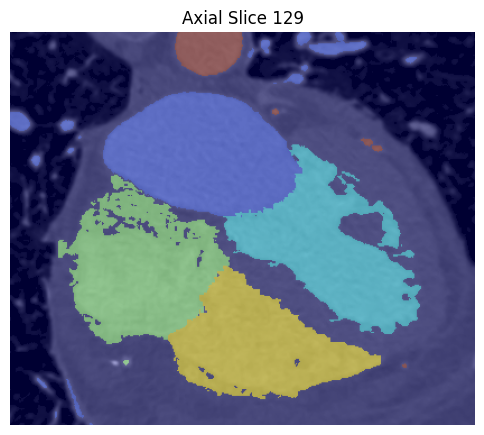

Saved: data\axial_slice_129.png


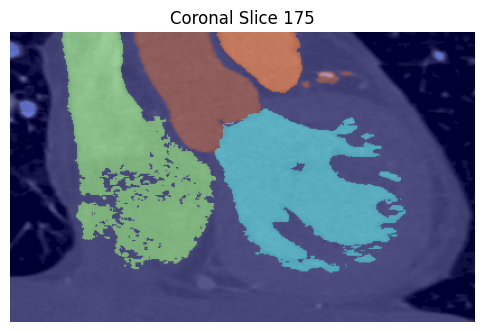

Saved: data\coronal_slice_175.png


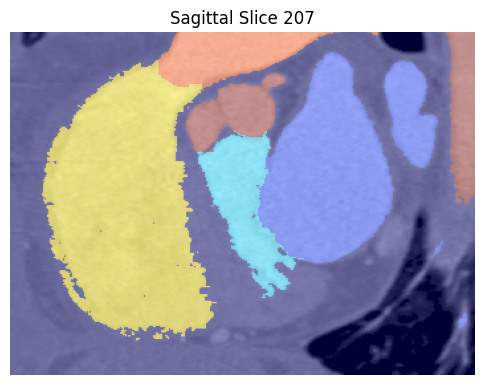

Saved: data\sagittal_slice_207.png


In [19]:
def plot_slice(img, mask, axis, slice_idx, title):
    plt.figure(figsize=(6,6))
    if axis == 'axial':
        img_slice = img[:, :, slice_idx]
        mask_slice = mask[:, :, slice_idx]
    elif axis == 'coronal':
        img_slice = img[:, slice_idx, :]
        mask_slice = mask[:, slice_idx, :]
    elif axis == 'sagittal':
        img_slice = img[slice_idx, :, :]
        mask_slice = mask[slice_idx, :, :]
    
    plt.imshow(img_slice.T, cmap='gray', origin='lower')
    plt.imshow(mask_slice.T, cmap='jet', alpha=0.4, origin='lower')
    plt.title(f"{title} Slice {slice_idx}")
    plt.axis('off')
    # Save and show
    filename = f"{axis}_slice_{slice_idx}.png"
    plt.savefig(os.path.join('data', filename), bbox_inches='tight', dpi=150)
    plt.show()
    print(f"Saved: {os.path.join('data', filename)}")

# Select middle slices
axial_idx = ct_scan_cropped.shape[2] // 2
coronal_idx = ct_scan_cropped.shape[1] // 2
sagittal_idx = ct_scan_cropped.shape[0] // 2

# Plot
plot_slice(ct_scan_cropped, ct_masks_cropped, 'axial', axial_idx, 'Axial')
plot_slice(ct_scan_cropped, ct_masks_cropped, 'coronal', coronal_idx, 'Coronal')
plot_slice(ct_scan_cropped, ct_masks_cropped, 'sagittal', sagittal_idx, 'Sagittal')

In [13]:
mesh_list = []
for i in range(1, 7):
    mesh = Mesh(f"data/meshes_colored/label_{i}.ply")
    mesh.compute_normals()
    mesh.alpha(0.5)  # Optional transparency
    mesh_list.append(mesh)

show(mesh_list, axes=1, viewup='z')

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [14]:
# Step 1: Threshold
threshold_mask = ((ct_scan_cropped >= 1305) & (ct_scan_cropped <= 2562)).astype(np.uint8)

# Step 2: Keep largest connected component
labeled_mask, num_features = label(threshold_mask)
sizes = np.bincount(labeled_mask.ravel())
sizes[0] = 0  # background = 0, ignore it

largest_label = sizes.argmax()
largest_component = (labeled_mask == largest_label).astype(np.uint8)

# Step 3: Subtract labels 3, 4, 5
structure_to_subtract = ((ct_masks_cropped == 3) | 
                         (ct_masks_cropped == 4) | 
                         (ct_masks_cropped == 5)).astype(np.uint8)

final_mask_step7 = np.logical_and(largest_component, np.logical_not(structure_to_subtract)).astype(np.uint8)

In [15]:
# Boolean union of labels 1, 2, and 6
mask_left_atrium     = (ct_masks_cropped == 1)
mask_left_ventricle  = (ct_masks_cropped == 2)
mask_aorta           = (ct_masks_cropped == 6)

# Combine all
final_mask_step8 = np.logical_or.reduce([mask_left_atrium, mask_left_ventricle, mask_aorta]).astype(np.uint8)

In [16]:
def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    volume_sum = np.sum(mask1) + np.sum(mask2)
    return (2.0 * intersection) / volume_sum if volume_sum != 0 else 1.0

def hausdorff_distance(mask1, mask2):
    from scipy.spatial.distance import directed_hausdorff
    coords1 = np.argwhere(mask1)
    coords2 = np.argwhere(mask2)
    if len(coords1) == 0 or len(coords2) == 0:
        return float('inf')
    hd1 = directed_hausdorff(coords1, coords2)[0]
    hd2 = directed_hausdorff(coords2, coords1)[0]
    return max(hd1, hd2)

# Dice score
dice = dice_score(final_mask_step7, final_mask_step8)
print(f"Dice Score: {dice:.4f}")

# Hausdorff distance in voxel units
hd_voxel = hausdorff_distance(final_mask_step7, final_mask_step8)

# Convert voxel spacing from header
voxel_spacing = np.abs(np.diag(space_directions))
hd_mm = hd_voxel * np.mean(voxel_spacing)
print(f"Hausdorff Distance: {hd_mm:.2f} mm")


voxel_volume_mm3 = np.prod(voxel_spacing)
vol1 = np.sum(final_mask_step7) * voxel_volume_mm3
vol2 = np.sum(final_mask_step8) * voxel_volume_mm3

print(f"Volume (Mask 7): {vol1:.2f} mm³")
print(f"Volume (Mask 8): {vol2:.2f} mm³")

Dice Score: 0.8379
Hausdorff Distance: 37.47 mm
Volume (Mask 7): 165005.74 mm³
Volume (Mask 8): 225895.40 mm³
